# Import required libraries

# Library Installation Guide
Install required libraries

In [3]:
!pip install discord.py
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install SpeechRecognition
!pip install pydub
!pip install joblib
!pip install deep-translator
!pip install seaborn
!pip install imbalanced-learn

## Additional System Requirements

In [5]:
# For speech recognition and audio processing:
"""1. Install FFmpeg (required for pydub):
    - Windows: Download from https://ffmpeg.org/download.html
    - Linux: sudo apt-get install ffmpeg
    - Mac: brew install ffmpeg
    
   2. Install PyAudio (required for speech_recognition):
    - Windows:
        !pip install pipwin
        !pipwin install pyaudio
"""

'1. Install FFmpeg (required for pydub):\n    - Windows: Download from https://ffmpeg.org/download.html\n    - Linux: sudo apt-get install ffmpeg\n    - Mac: brew install ffmpeg\n    \n   2. Install PyAudio (required for speech_recognition):\n    - Windows:\n        !pip install pipwin\n        !pipwin install pyaudio\n'

In [8]:
import discord
from discord.ext import commands
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import speech_recognition as sr
from pydub import AudioSegment
import os
import logging
import asyncio
import joblib
from deep_translator import GoogleTranslator
import seaborn as sns

# Emotion Detection Discord BotThis notebook implements a Discord bot that can detect emotions in text and voice messages.
The bot uses machine learning to classify emotions and responds with appropriate emoji reactions.

## Configuration
Set up the necessary configuration variables and logging


In [12]:
# Configuration
DISCORD_TOKEN = "Using discord token should be private"  # Replace this with Discord bot token
DATASET_PATH = r"Add path to your Go-Emotion dataset"  # Replace this with your dataset path
MODEL_PATH = 'emotion_model.pkl'

## Emotion Classifier
Implementation of the emotion classification system using scikit-learn

In [15]:
class EmotionClassifier:
    EMOTION_EMOJI_MAP = {
        "happy": "😊",
        "sad": "😢",
        "anger": "😡",
        "fear": "😨",
        "disgust": "🤢",
        "surprise": "😲",
        "neutral": "😐"
    }

    def __init__(self):
        self.model = None
        self.vectorizer = None
        self.last_evaluation_metrics = None

    def load_and_train(self):
        print("Loading and preprocessing dataset...")
        df = pd.read_csv(DATASET_PATH)
        emotion_columns = ['happy', 'sad', 'anger', 'disgust', 'surprise', 'fear', 'neutral']
        df['emotion'] = df[emotion_columns].idxmax(axis=1)
        df.dropna(subset=['text', 'emotion'], inplace=True)
        
        print(f"\nTotal samples in dataset: {len(df)}")
        
        X = df['text']
        y = df['emotion']
        
        print("\nVectorizing text data...")
        vectorizer = TfidfVectorizer(max_features=10000)
        X_tfidf = vectorizer.fit_transform(X)
        
        print("\nApplying SMOTE for class balancing...")
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)
        
        print("\nSplitting dataset into train and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42
        )
        
        print("\nTraining logistic regression model...")
        self.model = Pipeline([
            ('clf', LogisticRegression(max_iter=1000))
        ])
        self.model.fit(X_train, y_train)
        
        print("\nEvaluating model performance...")
        y_pred = self.model.predict(X_test)
        
        # Store evaluation metrics
        self.last_evaluation_metrics = {
            'classification_report': classification_report(y_test, y_pred),
            'test_samples': len(y_test),
            'train_samples': len(y_train)
        }
        
        print("\nClassification Report:")
        print(self.last_evaluation_metrics['classification_report'])
        
        # Plot confusion matrix with improved visualization
        plt.figure(figsize=(10, 8))
        ConfusionMatrixDisplay.from_estimator(
            self.model, X_test, y_test,
            cmap='Blues',
            normalize='true'
        )
        plt.title('Normalized Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        # Save model and vectorizer
        joblib.dump({'model': self.model, 'vectorizer': vectorizer}, MODEL_PATH)
        logging.info("Model trained and saved successfully.")

    def predict(self, text: str):
        if not self.model or not self.vectorizer:
            print("Loading saved model...")
            saved_data = joblib.load(MODEL_PATH)
            self.model = saved_data['model']
            self.vectorizer = saved_data['vectorizer']
    
        text_vectorized = self.vectorizer.transform([text])
        prediction = self.model.predict(text_vectorized)[0]
        probabilities = self.model.predict_proba(text_vectorized)[0]
        confidence = max(probabilities) * 100
        emoji = self.EMOTION_EMOJI_MAP.get(prediction, "❓")
        
        # Get all emotion probabilities
        emotion_probs = {
            emotion: prob * 100
            for emotion, prob in zip(self.model.classes_, probabilities)
        }
        
        # Print detailed prediction information
        print("\nPrediction Details:")
        print(f"Text converted from speech: {text}")
        print(f"Predicted Emotion: {prediction} {emoji}")
        print(f"Confidence: {confidence:.2f}%")
        print("\nAll Emotion Probabilities:")
        for emotion, prob in sorted(emotion_probs.items(), key=lambda x: x[1], reverse=True):
            emoji = self.EMOTION_EMOJI_MAP.get(emotion, "❓")
            print(f"{emotion} {emoji}: {prob:.2f}%")
        
        return prediction, emoji, confidence

## Voice Processor
Implementation of voice processing functionality using speech recognition

In [18]:
class VoiceProcessor:
    def __init__(self):
        self.recognizer = sr.Recognizer()

    async def process_voice_message(self, file_path: str):
        try:
            # Convert audio to wav format
            audio = AudioSegment.from_file(file_path)
            wav_path = "temp.wav"
            audio.export(wav_path, format="wav")

            # Perform speech recognition
            with sr.AudioFile(wav_path) as source:
                audio_data = self.recognizer.record(source)
            original_text = self.recognizer.recognize_google(audio_data)

            # Clean up temporary file
            os.remove(wav_path)

            # Translate text to English if necessary
            translated_text = GoogleTranslator(source='auto', target='en').translate(original_text)
            return translated_text

        except Exception as e:
            logging.error(f"Error processing voice: {e}")
            return ""

## Discord Bot
Implementation of the Discord bot that uses the emotion classifier and voice processor

In [21]:
class EmotionBot(commands.Bot):
    def __init__(self, classifier: EmotionClassifier):
        # Initialize bot with required intents
        intents = discord.Intents.default()
        intents.messages = True
        intents.message_content = True
        super().__init__(command_prefix="!", intents=intents)
        
        self.classifier = classifier
        self.voice_processor = VoiceProcessor()

    async def on_ready(self):
        logging.info(f'Bot connected as {self.user}')

    async def on_message(self, message: discord.Message):
        if message.author == self.user:
            return

        if message.attachments:
            await self.handle_voice_message(message)
        else:
            # Process text message
            text = GoogleTranslator(source='auto', target='en').translate(message.content)
            emotion, emoji, confidence = self.classifier.predict(text)
            if confidence > 90:
                await message.add_reaction(emoji)

    async def handle_voice_message(self, message: discord.Message):
        file_path = 'voice_message.ogg'
        await message.attachments[0].save(file_path)
        
        # Process voice message
        text = await self.voice_processor.process_voice_message(file_path)
        os.remove(file_path)
        
        if text:
            emotion, emoji, confidence = self.classifier.predict(text)
            if confidence > 75:
                await message.add_reaction(emoji)
            logging.info(f"Voice Text: {text} | Emotion: {emotion} | Confidence: {confidence:.2f}%")

## Main Execution
Run the bot with the trained emotion classifier


In [24]:
import nest_asyncio
import asyncio
from IPython.display import clear_output

# Apply nest_asyncio to allow nested event loops in Jupyter
nest_asyncio.apply()

In [26]:
async def main():
    try:
        # Initialize and train the classifier
        classifier = EmotionClassifier()
        print("Training the emotion classifier...")
        classifier.load_and_train()
        print("Classifier training completed!")
        
        # Create and start the bot
        bot = EmotionBot(classifier)
        print("Starting the Discord bot...")
        await bot.start(DISCORD_TOKEN)
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        traceback.print_exc()
    finally:
        # Cleanup
        if 'bot' in locals():
            await bot.close()

Starting the application...
Training the emotion classifier...
Loading and preprocessing dataset...

Total samples in dataset: 90698

Vectorizing text data...

Applying SMOTE for class balancing...

Splitting dataset into train and test sets...

Training logistic regression model...

Evaluating model performance...

Classification Report:
              precision    recall  f1-score   support

       anger       0.71      0.66      0.68     11050
     disgust       0.77      0.77      0.77     11173
        fear       0.83      0.82      0.83     11167
       happy       0.79      0.79      0.79     10891
     neutral       0.62      0.58      0.60     10985
         sad       0.80      0.72      0.76     11105
    surprise       0.66      0.83      0.74     11047

    accuracy                           0.74     77418
   macro avg       0.74      0.74      0.74     77418
weighted avg       0.74      0.74      0.74     77418



<Figure size 1000x800 with 0 Axes>

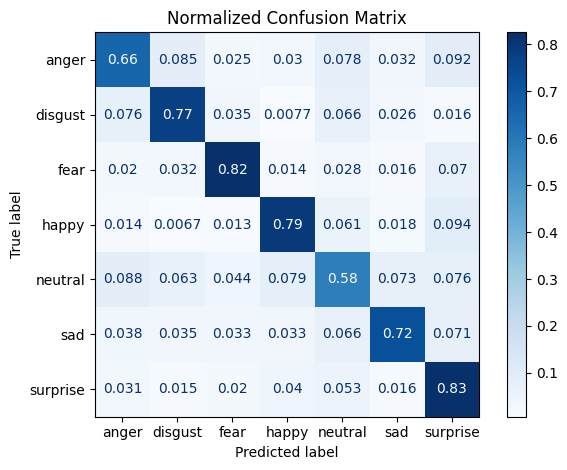

Classifier training completed!
Starting the Discord bot...
Loading saved model...

Prediction Details:
Text converted from speech: today I am very happy
Predicted Emotion: happy 😊
Confidence: 99.37%

All Emotion Probabilities:
happy 😊: 99.37%
sad 😢: 0.57%
neutral 😐: 0.04%
surprise 😲: 0.01%
anger 😡: 0.00%
disgust 🤢: 0.00%
fear 😨: 0.00%

Prediction Details:
Text converted from speech: I have a fear of heights
Predicted Emotion: fear 😨
Confidence: 99.97%

All Emotion Probabilities:
fear 😨: 99.97%
sad 😢: 0.02%
anger 😡: 0.00%
neutral 😐: 0.00%
disgust 🤢: 0.00%
happy 😊: 0.00%
surprise 😲: 0.00%

Prediction Details:
Text converted from speech: I am very happy to meet you
Predicted Emotion: happy 😊
Confidence: 99.83%

All Emotion Probabilities:
happy 😊: 99.83%
sad 😢: 0.10%
neutral 😐: 0.05%
surprise 😲: 0.01%
anger 😡: 0.01%
disgust 🤢: 0.00%
fear 😨: 0.00%

Prediction Details:
Text converted from speech: how can you say that it's not appropriate
Predicted Emotion: disgust 🤢
Confidence: 59.62%

All E

In [ ]:
if __name__ == '__main__':
    try:
        # Get or create event loop
        try:
            loop = asyncio.get_event_loop()
        except RuntimeError:
            loop = asyncio.new_event_loop()
            asyncio.set_event_loop(loop)
        
        # Run the bot
        print("Starting the application...")
        loop.run_until_complete(main())
    except KeyboardInterrupt:
        print("\nShutting down gracefully...")
    except Exception as e:
        print(f"Fatal error: {str(e)}")
        traceback.print_exc()
    finally:
        # Clean up
        loop.close()
        print("Application shutdown complete.")
